# Inverse Correlated LETF Pair Trading

The Leveraged ETF pair provide higher return through leverage while lowering risk through inverse correlated pairs.

*References:* 

1. Gayed, Michael and Bilello, Charles, Leverage for the Long Run - A Systematic Approach to Managing Risk and Magnifying Returns in Stocks (March 3, 2016). 2016 Charles H. Dow Award, Available at SSRN: https://ssrn.com/abstract=2741701 or http://dx.doi.org/10.2139/ssrn.2741701

2. Andreas Clenow, Trading Evolved, 2019

**Trading Rule**

1. LETFs: TMF and TQQQ
    
2. Rebalancing period: Monthly
    
3. Allocation based on inverse volatility. Volatility calculation: Last 20 day standard deviation of daily percent change.

In [1]:
import zipline
from zipline.api import order_target_percent, symbol, schedule_function, date_rules, time_rules, set_benchmark

from datetime import datetime
import pytz

from matplotlib import pyplot as plt, ticker, rc
import pandas as pd
import numpy as np
from scipy import stats

import pyfolio as pf

In [2]:
"""
    Model Settings
"""
INIT_PORTFOLIO = 10000
VOLA_WINDOW = 20
LOOKBACK_WINDOW = 126

def volatility(ts):
    std = ts.pct_change().dropna().rolling(VOLA_WINDOW).std().iloc[-1]    
    return std

In [3]:
def initialize(context):
    # Used for history window
    context.vola_window = VOLA_WINDOW
    context.lookback_window = LOOKBACK_WINDOW
    
    # ETF selected
    etfs = ['TMF', 'TQQQ']
    context.etfs = [symbol(s) for s in etfs]
    
#    set_benchmark(False)
    set_benchmark(symbol('SPY'))
    
    # Schedule rebalance for once a month
    schedule_function(rebalance, date_rules.month_start(), time_rules.market_open())

In [4]:
def rebalance(context, data):
    # Get historical data for lookback window for volatility calculation
    hist = data.history(context.etfs, "close", LOOKBACK_WINDOW, "1d")
    hist = hist.dropna()
    
    # Calculate inverse volatility for etfs and make target positions weights
    vola_table = hist[context.etfs].apply(volatility)
    inv_vola_table = 1 / vola_table
    sum_inv_vola = np.sum(inv_vola_table)
    vola_target_weights = inv_vola_table / sum_inv_vola
    
    # place order for targeted weights
    for etf in context.etfs:
        weight = vola_target_weights[etf]
        order_target_percent(etf, weight)

In [5]:
# set start and end date
# TQQQ/TMF
start = pd.to_datetime('2010-03-11', utc=True)
# TQQQSIM/TMFSIM
#start = pd.to_datetime('2002-08-31', utc=True)
end = pd.to_datetime('2020-12-31', utc=True)

# start backtest
result = zipline.run_algorithm(
    start = start, 
    end = end, 
    initialize = initialize, 
    capital_base = INIT_PORTFOLIO, 
    data_frequency = 'daily', 
    bundle = 'etf_db_data')

/opt/anaconda3/envs/zipreload/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/opt/anaconda3/envs/zipreload/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/opt/anaconda3/envs/zipreload/lib/python3.8/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/opt/anaconda3/envs/zipreload/lib/python3.8/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


Start date,2010-03-11
End date,2020-12-31
Total months,129
,Backtest
Annual return,43.38%
Cumulative returns,4808.509%
Annual volatility,27.657%
Sharpe ratio,1.44
Calmar ratio,1.01
Stability,0.97
Max drawdown,-42.966%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,42.97,2020-03-09,2020-03-18,2020-04-16,29
1,23.27,2016-09-28,2016-12-01,2017-04-17,144
2,22.84,2018-08-30,2018-11-02,2019-02-19,124
3,22.57,2020-09-02,2020-10-30,NaT,NaN
4,21.15,2012-09-06,2013-06-24,2013-10-18,292


/opt/anaconda3/envs/zipreload/lib/python3.8/site-packages/pandas/core/indexes/base.py:5277: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.41%,-6.21%,4.98%
Fukushima,0.10%,-2.19%,2.01%
EZB IR Event,-0.31%,-3.04%,2.18%
Flash Crash,-0.51%,-5.73%,2.83%
Apr14,0.20%,-2.44%,2.07%
Oct14,0.28%,-3.01%,2.67%
Fall2015,-0.36%,-5.00%,3.58%
Recovery,0.19%,-6.21%,6.57%
New Normal,0.15%,-16.91%,15.11%


Top 10 long positions of all time,max
sid,
TMF,91.63%
TQQQ,75.23%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
TMF,91.63%
TQQQ,75.23%


Summary stats,All trades,Long trades
Total number of round_trips,129.00,129.00
Percent profitable,0.79,0.79
Winning round_trips,102.00,102.00
Losing round_trips,27.00,27.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$481035.29,$481035.29
Gross profit,$535139.48,$535139.48
Gross loss,$-54104.18,$-54104.18
Profit factor,$9.89,$9.89
Avg. trade net profit,$3728.96,$3728.96
Avg. winning trade,$5246.47,$5246.47
Avg. losing trade,$-2003.86,$-2003.86
Ratio Avg. Win:Avg. Loss,$2.62,$2.62
Largest winning trade,$98624.50,$98624.50
Largest losing trade,$-30617.98,$-30617.98


Duration stats,All trades,Long trades
Avg duration,344 days 02:16:16.759689924,344 days 02:16:16.759689924
Median duration,337 days 00:00:00,337 days 00:00:00
Longest duration,637 days 23:00:00,637 days 23:00:00
Shortest duration,29 days 00:00:00,29 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,2.48%,2.48%
Avg returns winning,3.48%,3.48%
Avg returns losing,-1.32%,-1.32%
Median returns all round_trips,1.85%,1.85%
Median returns winning,2.54%,2.54%
Median returns losing,-0.82%,-0.82%
Largest winning trade,20.21%,20.21%
Largest losing trade,-6.27%,-6.27%


Symbol stats,TMF,TQQQ
Avg returns all round_trips,2.56%,2.42%
Avg returns winning,3.58%,3.41%
Avg returns losing,-1.53%,-1.18%
Median returns all round_trips,2.43%,1.51%
Median returns winning,3.08%,2.11%
Median returns losing,-1.02%,-0.51%
Largest winning trade,11.27%,20.21%
Largest losing trade,-5.53%,-6.27%


Profitability (PnL / PnL total) per name,
symbol,
TQQQ,79.58%
TMF,20.42%


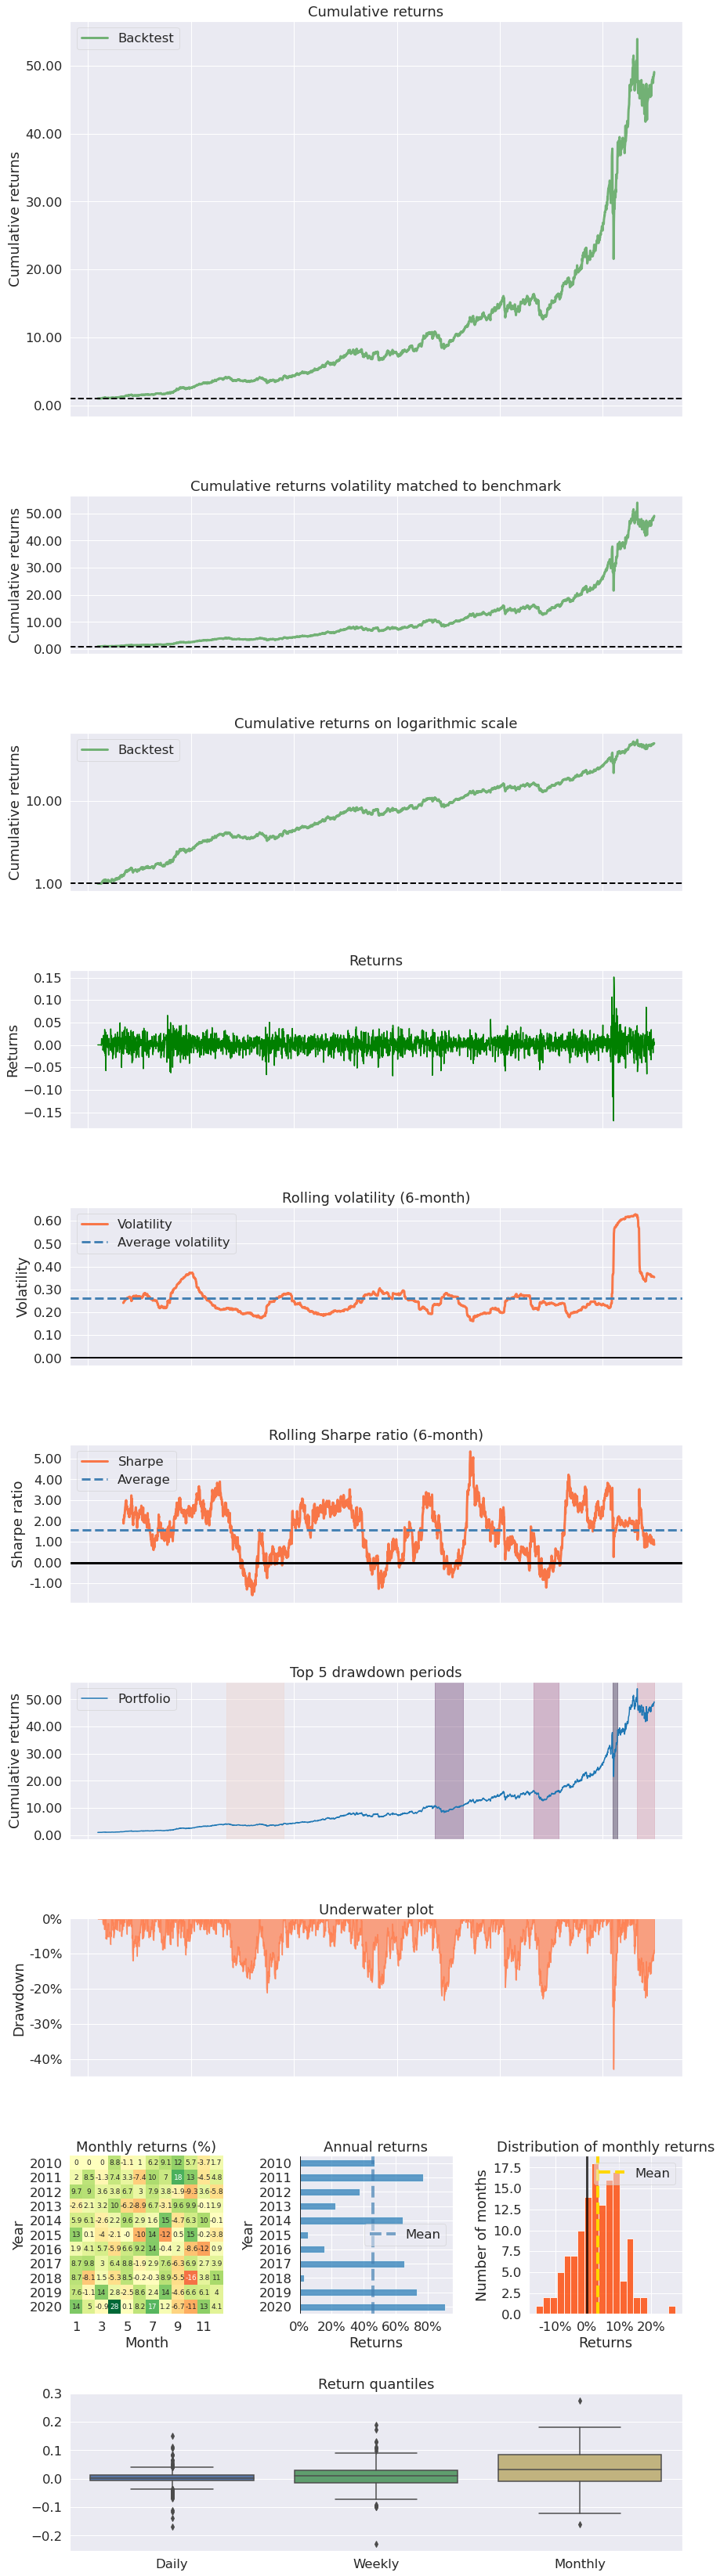

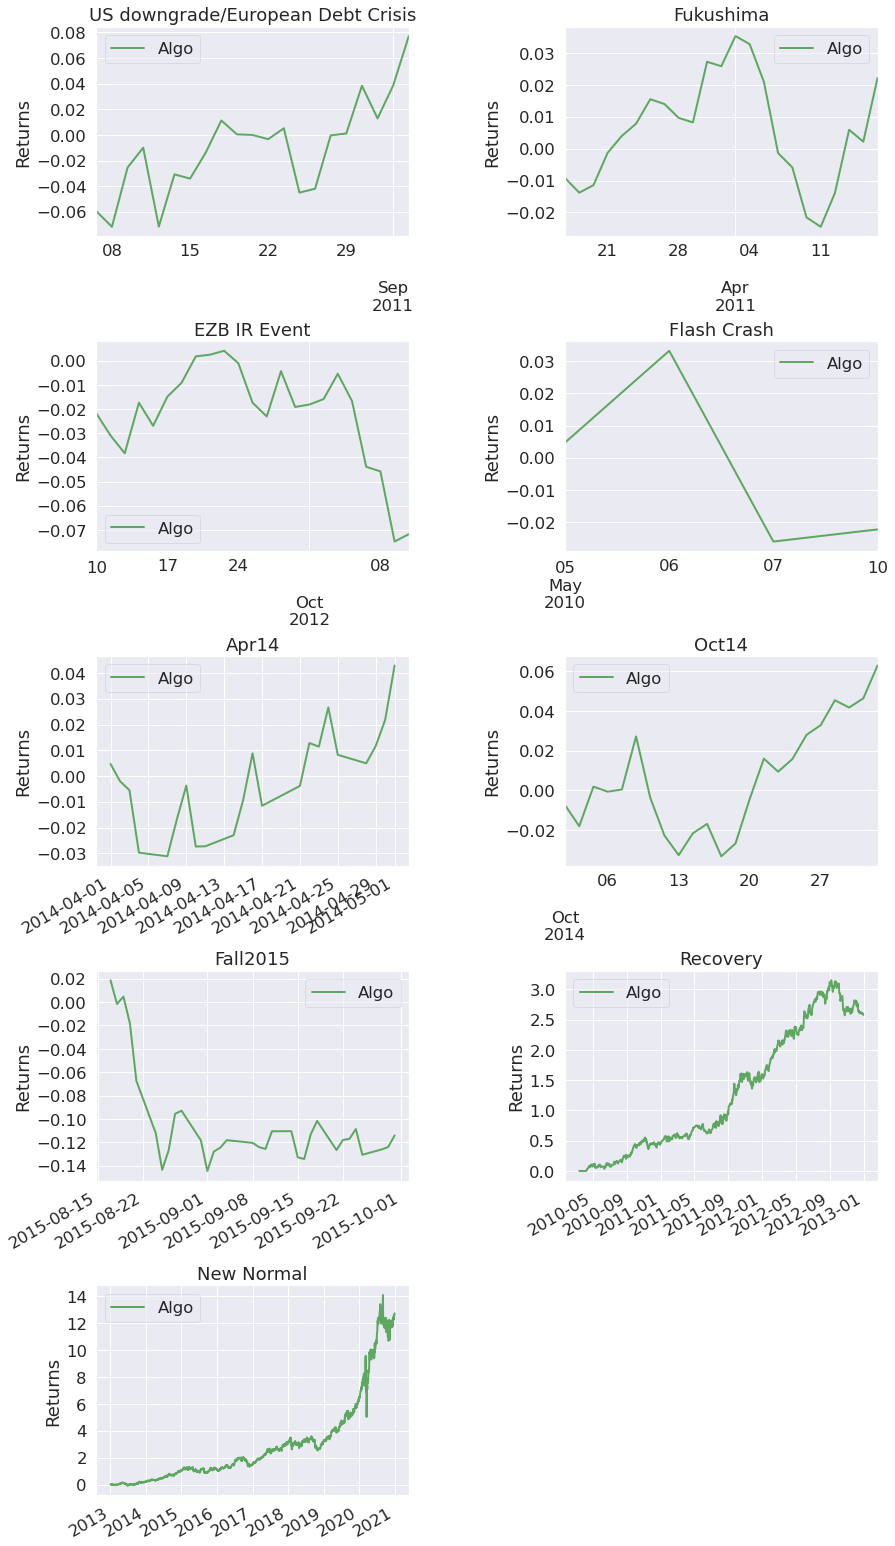

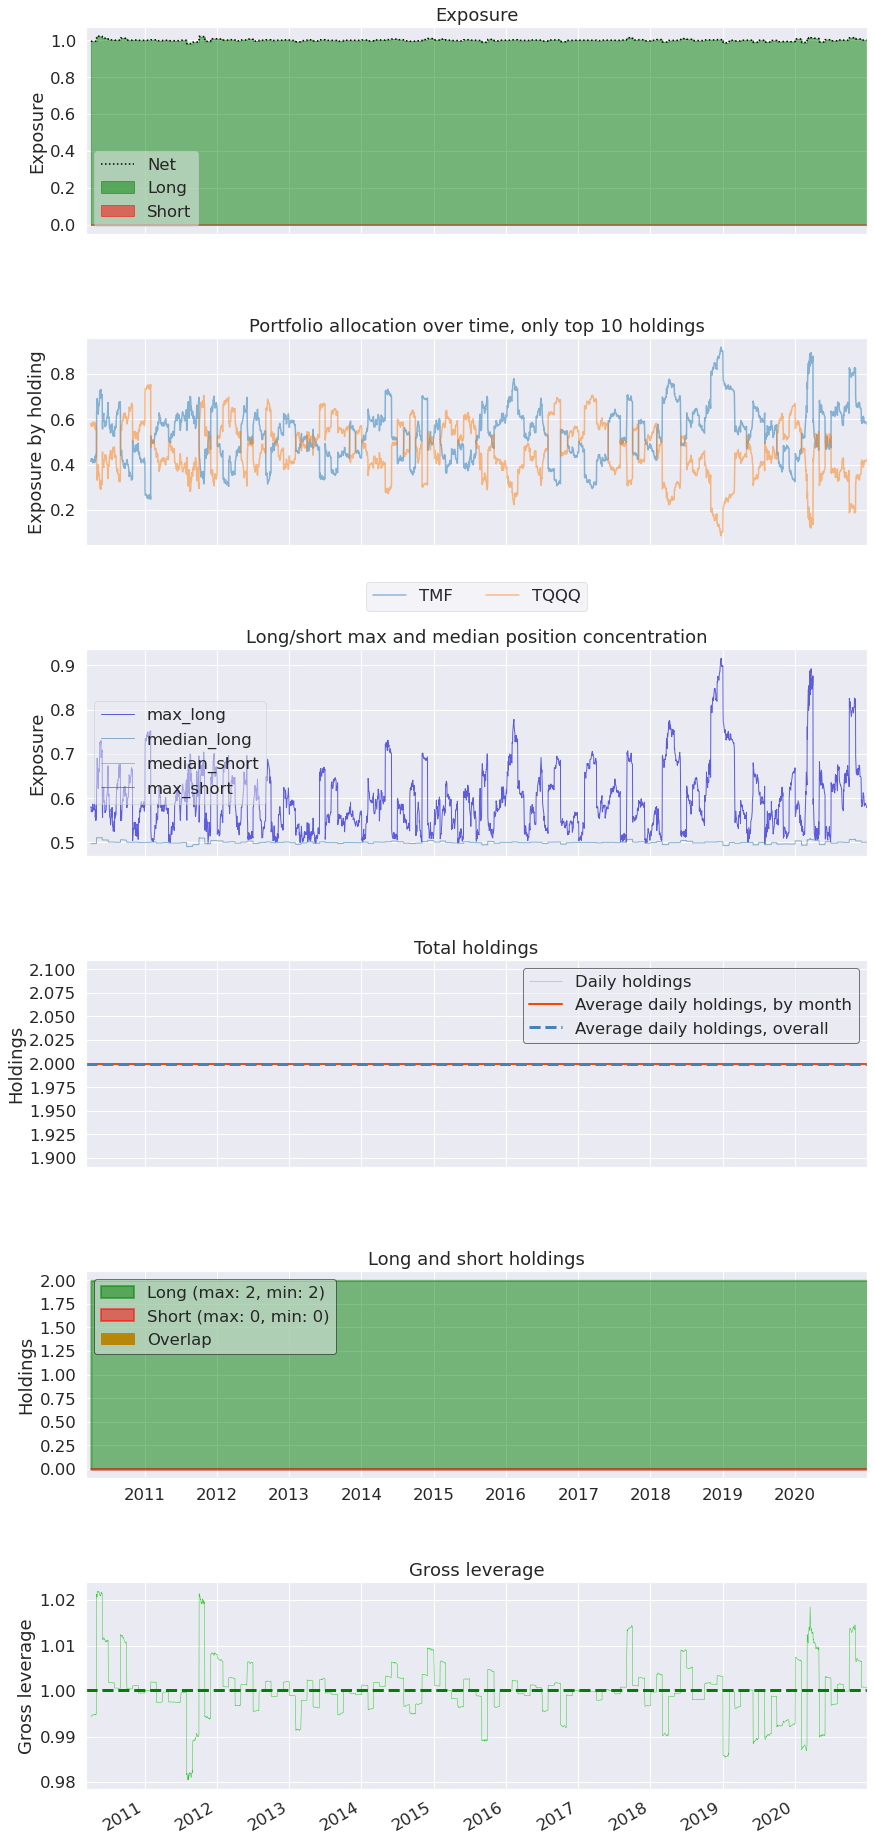

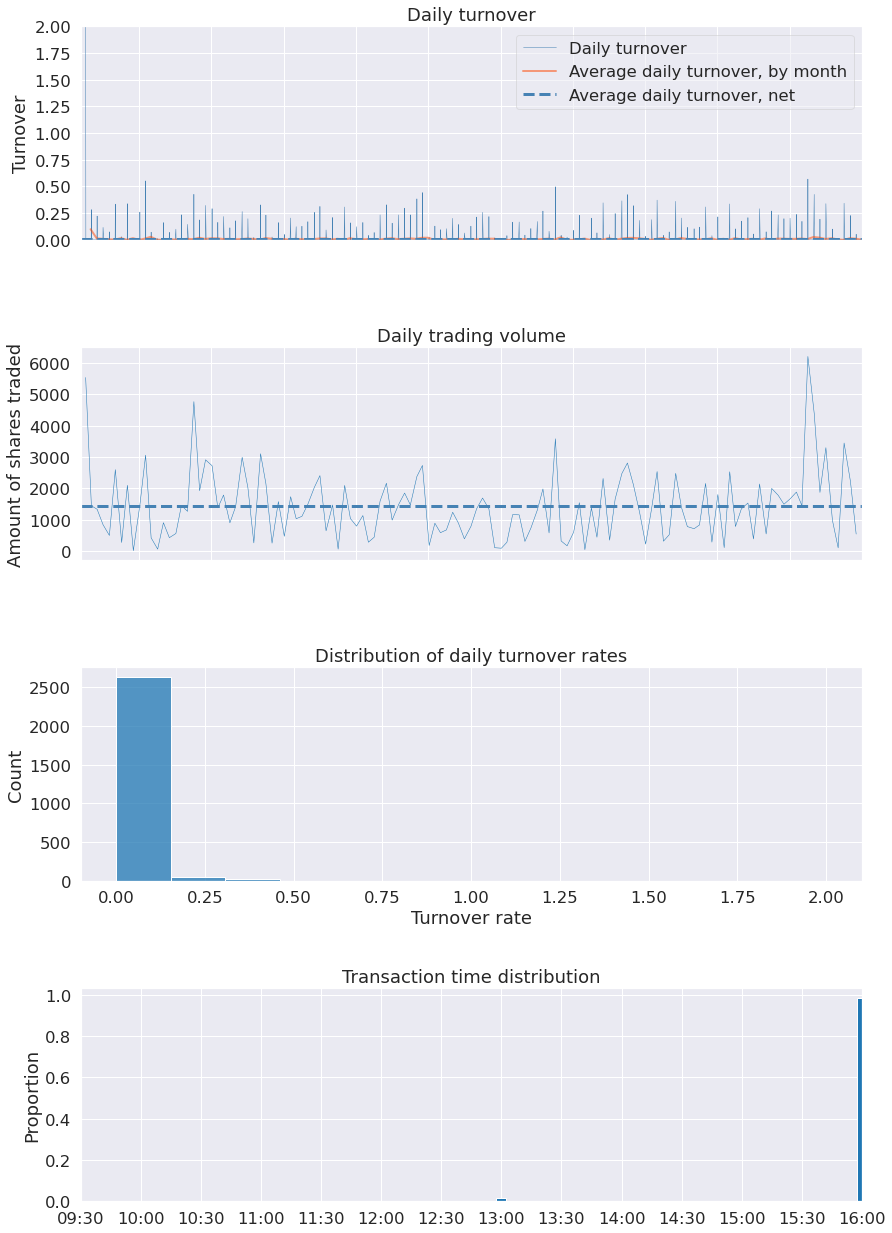

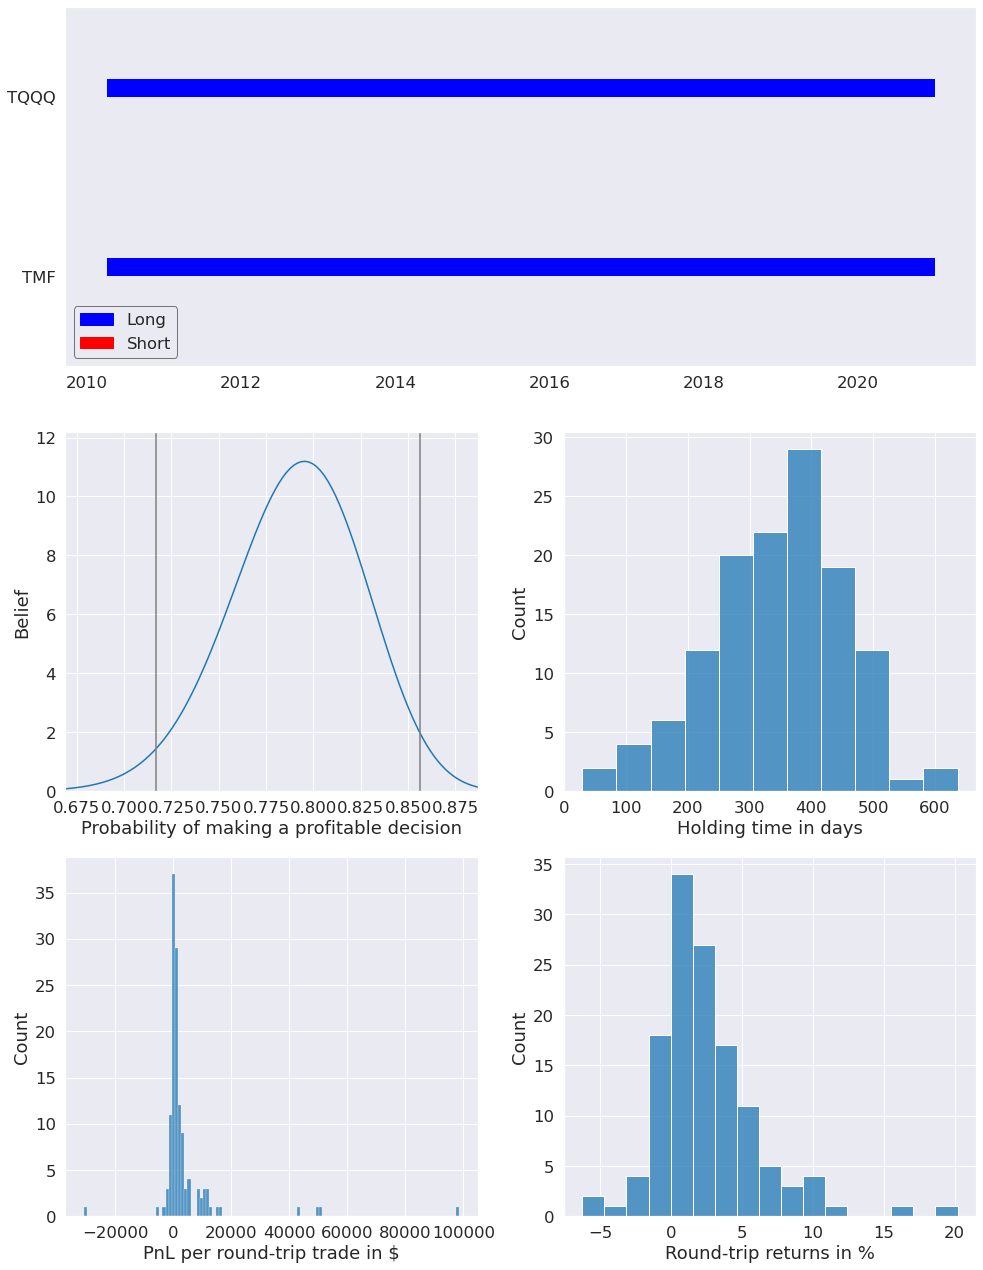

In [6]:
# Performance Analysis - Pyfolio Returns Tear Sheet
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions, round_trips = True, 
                          benchmark_rets = None)
#pf.create_returns_tear_sheet(returns, benchmark_rets = None)

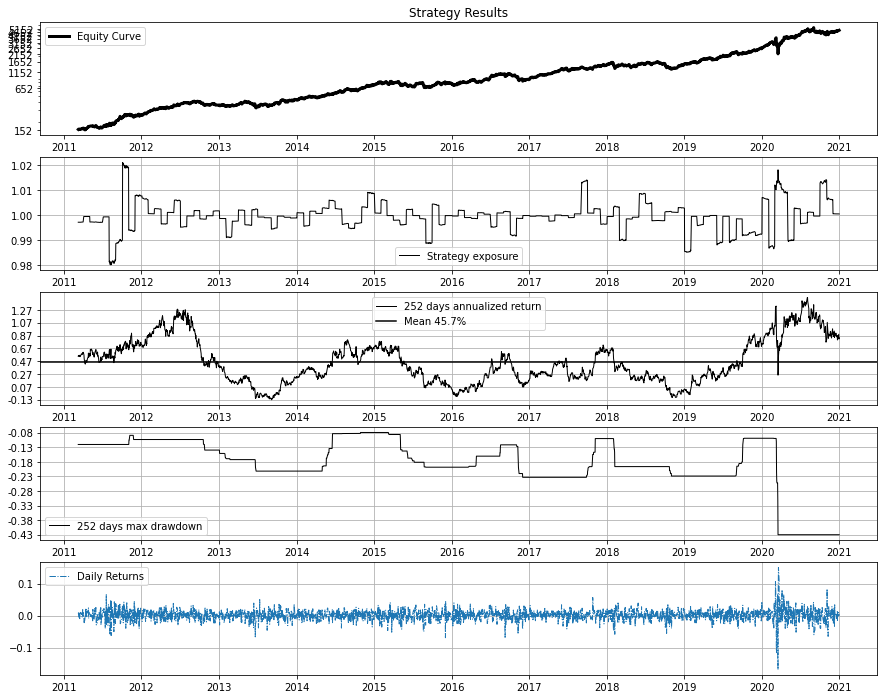

In [7]:
# Settings
window = 252
year_length = 252

# Copy the columns we need
df = result.copy().filter(items=['portfolio_value', 'gross_leverage', 'returns'])

# Function for annualized return
def ann_ret(ts):
    return np.power((ts[-1] / ts[0]), (year_length/len(ts))) -1  

# Function for drawdown
def dd(ts):
    return np.min(ts / np.maximum.accumulate(ts)) - 1

# Get a rolling window
rolling_window = result.portfolio_value.rolling(window)

# Calculate rolling analytics
df['annualized'] = rolling_window.apply(ann_ret)
df['drawdown'] = rolling_window.apply(dd)

# Drop initial n/a values
df.dropna(inplace=True)

# Make a figure
fig = plt.figure(figsize=(15, 12))

# Make the base lower, just to make the graph easier to read
df['portfolio_value'] /= 100

# First chart
ax = fig.add_subplot(511)
ax.set_title('Strategy Results')
ax.plot(df['portfolio_value'], 
        linestyle='-', 
        color='black',
        label='Equity Curve', linewidth=3.0)

# Set log scale
ax.set_yscale('log') 

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['portfolio_value'].min(), df['portfolio_value'].max(), 500 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# Add legend and grid
ax.legend()
ax.grid(False)

# Second chart
ax = fig.add_subplot(512)
ax.plot(df['gross_leverage'], 
        label='Strategy exposure'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['gross_leverage'].min(), df['gross_leverage'].max(), 0.01 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Third chart
ax = fig.add_subplot(513)
ax.plot(df['annualized'], 
        label='{} days annualized return'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)
ax.axhline(df['annualized'].mean(), color='black', linewidth=1.5, 
           label='Mean {:0.1f}%'.format(df['annualized'].mean() * 100))

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['annualized'].min(), df['annualized'].max(), 0.2 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fourth chart
ax = fig.add_subplot(514)
ax.plot(df['drawdown'], 
        label='{} days max drawdown'.format(window), 
        linestyle='-', 
        color='black',
        linewidth=1.0)

# Make the axis look nicer
ax.yaxis.set_ticks(np.arange(df['drawdown'].min(), df['drawdown'].max(), 0.05 ))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

# Add legend and grid
ax.legend()
ax.grid(True)

# Fifth chart
ax = fig.add_subplot(515)
ax.plot(df['returns'], label = 'Daily Returns', linestyle='-.', linewidth = 1.0)
ax.legend()
ax.grid(True)

In [8]:
"""
    Monthly Time Return Table
"""


# Used for performance calculations
import empyrical as em

# Used for displaying HTML formatted content in notebook
from IPython.core.display import display, HTML

# Use Empyrical to aggregate on monthly and yearly periods
monthly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'monthly')
yearly_data = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')

# Start off an HTML table for display
# HTML Table for display
table = """
<table class='table table-hover table-condensed table-striped'>
<thead>
<tr>
<th style="text-align:right">Year</th>
<th style="text-align:right">Jan</th>
<th style="text-align:right">Feb</th>
<th style="text-align:right">Mar</th>
<th style="text-align:right">Apr</th>
<th style="text-align:right">May</th>
<th style="text-align:right">Jun</th>
<th style="text-align:right">Jul</th>
<th style="text-align:right">Aug</th>
<th style="text-align:right">Sep</th>
<th style="text-align:right">Oct</th>
<th style="text-align:right">Nov</th>
<th style="text-align:right">Dec</th>
<th style="text-align:right">Year</th>
</tr>
</thead>
<tbody>
<tr>"""

# initialize
first_year = True
first_month = True
yr = 0
mnth = 0

# iterate over pandas series
for m, val in monthly_data.iteritems():
    yr = m[0]
    mnth = m[1]
    
    # first month of year, add year label to table
    if (first_month):
        table += "<td align='right'><b>{}</b></td>\n".format(yr)
        first_month = False
    
    # pad empty months for first year if simulation starts later in year
    if (first_year):
        first_year = False
        if (mnth > 1):
            for i in range(1, mnth):
                table += "<td align='right'>-</td>\n"
                
    # add monthly performance
    table += "<td align='right'>{:+.1f}</td>\n".format(val * 100)
    
    # check for 12th month, add annual return number
    if (mnth == 12):
        table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
        table += '</tr>\n<tr>\n'
        first_month = True
        
# pad empty months for last year
if (mnth != 12):
    for i in range(mnth + 1, 13):
        table +="<td align='right'><b>\n"
        if (i == 12):
            table += "<td align='right'><b>{:+.1f}</b></td>\n".format(yearly_data[yr] * 100)
            table += '</tr>\n<tr>\n'

# finalize table
table += '</tr>\n</tbody>\n</table>'

display(HTML(table))

Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year
2010,-,-,+0.0,+8.8,-1.1,+1.0,+6.2,+9.1,+12.5,+5.7,-3.7,+1.7,+46.8
2011,+2.0,+8.5,-1.3,+7.4,+3.3,-7.4,+10.1,+7.0,+18.2,+13.3,-4.5,+4.8,+77.1
2012,+9.7,+9.0,+3.6,+3.8,+6.7,+3.0,+7.9,+3.8,-1.9,-9.3,+3.6,-5.8,+37.6
2013,-2.6,+2.1,+3.2,+10.3,-6.2,-8.9,+6.7,-3.1,+9.6,+9.9,-0.1,+1.9,+22.5
2014,+5.9,+6.1,-2.6,+2.2,+9.6,+2.9,+1.6,+14.8,-4.7,+6.3,+10.5,-0.1,+64.5
2015,+12.6,+0.1,-4.0,-2.1,-0.0,-10.2,+13.6,-12.1,+0.5,+14.7,-0.2,-3.8,+5.0
2016,+1.9,+4.1,+5.7,-5.9,+6.6,+9.2,+13.9,-0.4,+2.0,-8.6,-11.8,+0.9,+15.6
2017,+8.7,+9.8,+3.0,+6.4,+8.8,-1.9,+2.9,+7.6,-6.3,+6.9,+2.7,+3.9,+65.3
2018,+8.7,-8.1,+1.5,-5.3,+8.5,-0.2,-0.3,+8.9,-5.5,-16.0,+3.8,+10.6,+3.0
2019,+7.6,-1.1,+13.8,+2.8,-2.5,+8.6,+2.4,+14.3,-4.6,+6.6,+6.1,+4.0,+72.9


In [9]:
"""
    Holding period table

    Shows percentage return if you started in January of a given year and held for certain number of full years.
    In Table you can see what would have happened if you strated this strategy at a given year, and kept trading it
    for number of years from that point. This can be a useful way to quickly get an overview of how the initial
    starting time sometimes can matter quite a lot for a trading model. The numbers show annualized return over
    the number of years displayed on the x-axis.
"""


def holding_period_map(df):
    
    # agreegate yearly data
    yr = em.aggregate_returns(result['portfolio_value'].pct_change(), 'yearly')
    df = pd.DataFrame(columns=range(1,len(yr)+1), index=yr.index)

    yr_start = 0
    
    # start table
    table = "<table class='table table-hover table-condensed table-striped'>"
    table += "<tr><th>Years</th>"
    
    # build first row
    for i in range(len(yr)):
        table += "<th>{}</th>".format(i+1)
    table += "</tr>"

    # iterate years
    for the_year, value in yr.iteritems():
        # new table row
        table += "<tr><th>{}</th>".format(the_year)
        
        # iterate years held
        for yrs_held in (range(1, len(yr)+1)):
            if yrs_held   <= len(yr[yr_start:yr_start + yrs_held]):
                ret = em.annual_return(yr[yr_start:yr_start + yrs_held], 'yearly' )
                table += "<td>{:+.1f}</td>".format(ret * 100)
        table += "</tr>"    
        yr_start+=1
    return table

table = holding_period_map(df)
display(HTML(table))

ValueError: Wedge sizes 'x' must be non negative values

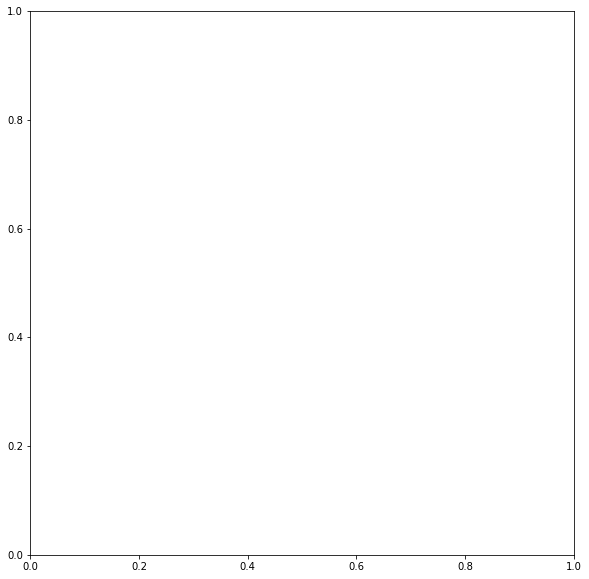

In [10]:
"""
    Portfolio Day Snapshot snapshot
"""

# day to view
day = '2020-12-31'

# get portfolio value and positions for this day
port_value = result.loc[day, 'portfolio_value']
day_positions = result.loc[day, 'positions']

df = pd.DataFrame(columns = ['value', 'pnl'])
# populate with position info
for pos in day_positions:
    ticker = pos['sid'].symbol
    df.loc[ticker,'value'] = pos['amount'] * pos['last_sale_price']
    df.loc[ticker,'pnl'] = df.loc[ticker,'value'] - (pos['amount'] * pos['cost_basis'])
    
# cash position
df.loc['cash', ['value', 'pnl']] = [(port_value - df['value'].sum()), 0]

# pie chart for allocation
fig, ax1 = plt.subplots(figsize = [12, 10])
ax1.pie(df['value'], labels = df.index, shadow = True, startangle = 90)
ax1.axis('equal')
ax1.set_title('Allocation on {}'.format(day))
plt.show()

# bar chart for open PnL
fig, ax1 = plt.subplots(figsize = [12, 10])
pnl_df = df.drop('cash')
ax1.barh(pnl_df.index, pnl_df['pnl'], align = 'center', color = 'green', ecolor = 'black')
ax1.set_title('Open PnL on {}'.format(day))
plt.show()